In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import xgboost as xgb
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from xgboost import plot_importance, plot_tree

In [4]:
# lib configuration
register_matplotlib_converters()
plt.rcParams["figure.figsize"] = (15,8)

In [5]:
# https://www.kaggle.com/mczielinski/bitcoin-historical-data
DATASET_PATH = "data/bitcoin-historical.csv"

In [6]:
df = pd.read_csv(DATASET_PATH)

In [7]:
old_size = df.size

In [8]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data transforamtion

Dataset contains a lot of empty rows, we should wipe out that unnecessary data. Also, we should map unix timestamps to normal datetime objects

In [9]:
df = df.dropna(thresh=3)

In [10]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


In [11]:
# amount of dropped rows (huge)
old_size - df.size

9855024

In [12]:
# copnver unit timestamp to datetime object
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

In [13]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


Text(0, 0.5, 'Cost of Bition in USD')

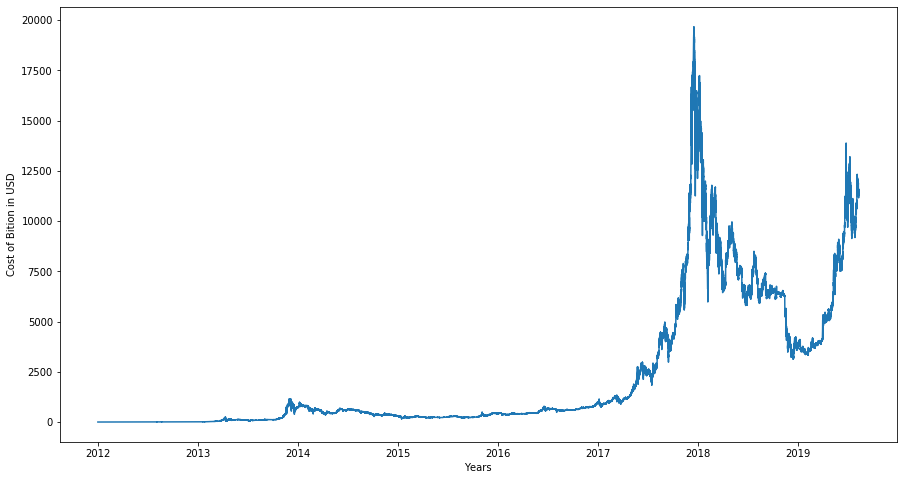

In [14]:
plt.plot(df['Timestamp'], df['High'])
plt.xlabel('Years')
plt.ylabel('Cost of Bition in USD')

As we see, bitcoin data is pretty unpreditable. No model could predict all of those spikes, due to this fact I will train models on small section of dataset.

In [47]:
split_date = '2018-01-01'
df_cut = df.loc[df['Timestamp'] >= split_date].copy()

Text(0.5, 1.0, 'Bitcoin 2018-01-01 to 2019-08-12')

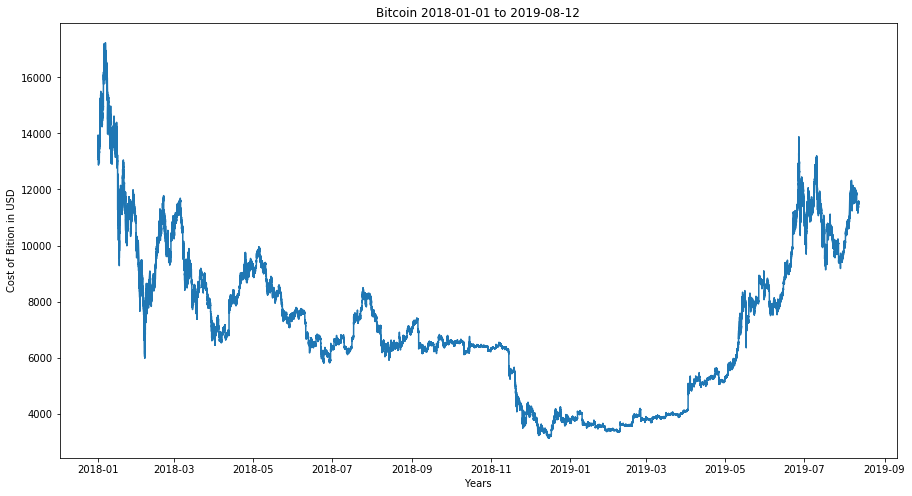

In [48]:
plt.plot(df_cut['Timestamp'], df_cut['High'])
plt.xlabel('Years')
plt.ylabel('Cost of Bition in USD')
plt.title("Bitcoin 2018-01-01 to 2019-08-12")

In [49]:
train_split = '2019-05-15'
bitcoin_train = df_cut.loc[df_cut['Timestamp'] <= train_split].copy()
bitcoin_test = df_cut.loc[df_cut['Timestamp'] > train_split].copy()

Text(0.5, 1.0, 'Splitted dateset')

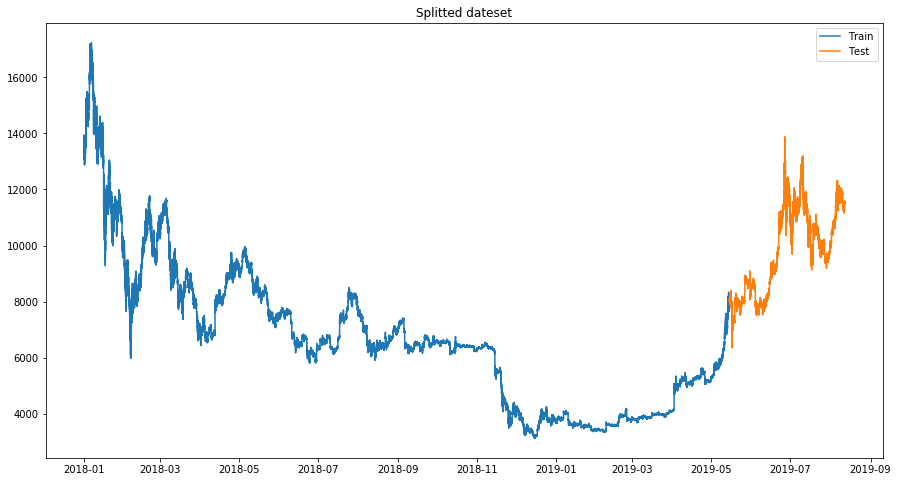

In [50]:
plt.plot(bitcoin_train['Timestamp'], bitcoin_train['High'], label='Train')
plt.plot(bitcoin_test['Timestamp'], bitcoin_test['High'], label='Test')
plt.legend(loc='best')
plt.title("Splitted dateset")

In [51]:
# borrow (with some tweaks) those functions from previous notebook

def create_features_dep(df, x_label='Timestamp', y_label='High'):
    return df[x_label].as_matrix().reshape((-1,1)), df[y_label].as_matrix()


def create_features(df, x_label='Timestamp', y_label='High'):
    # removed year feature, as we are working on 1.5 year sample
    df['hour'] = df[x_label].dt.hour
    df['quarter'] = df[x_label].dt.quarter
    df['month'] = df[x_label].dt.month
    df['dayofyear'] = df[x_label].dt.dayofyear
    df['dayofmonth'] = df[x_label].dt.day
    df['weekofyear'] = df[x_label].dt.weekofyear
    
    X = df[['hour','dayofyear','quarter','month', 'weekofyear', 'dayofmonth']]
    y = df[y_label]

    return X, y

In [52]:
X_train, y_train = create_features(bitcoin_train)
X_test, y_test = create_features(bitcoin_test)

In [53]:
X_train

,hour,dayofyear,quarter,month,weekofyear,dayofmonth
3150976,0,1,1,1,1,1
3150977,0,1,1,1,1,1
3150978,0,1,1,1,1,1
3150979,0,1,1,1,1,1
3150980,0,1,1,1,1,1
...,...,...,...,...,...,...
3869532,23,134,2,5,20,14
3869533,23,134,2,5,20,14
3869534,23,134,2,5,20,14
3869535,23,134,2,5,20,14


### Predictions - using XGBoost (XGBRegressor)

In [54]:
reg = xgb.XGBRegressor(n_estimators=1500, booster='dart', n_jobs=8, importance_type='weight')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False) # too much logs 

[23:16:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='weight', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1500,
             n_jobs=8, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Again let's check importance of each feature

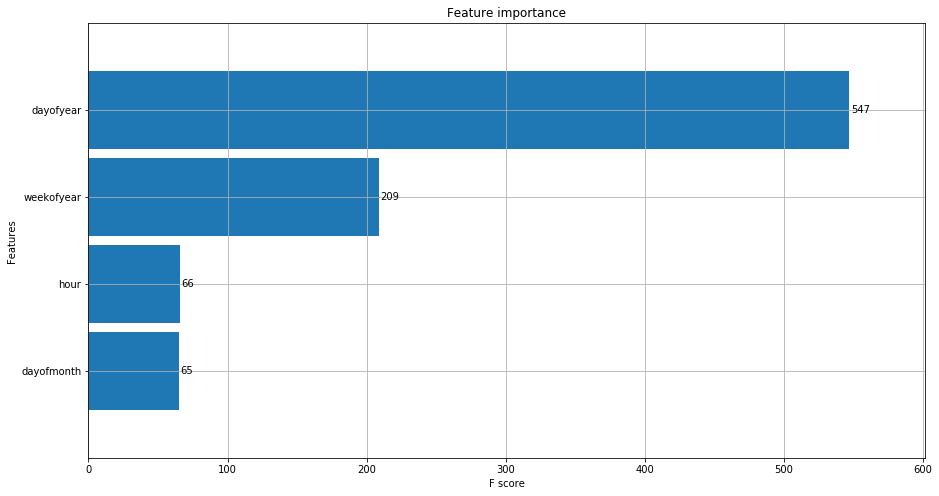

In [55]:
plot_importance(reg, height=0.9)

As everyone should predict (lol), day of year is the most significant feature in our dataset

In [56]:
bitcoin_test['hight_prediction'] = reg.predict(X_test)

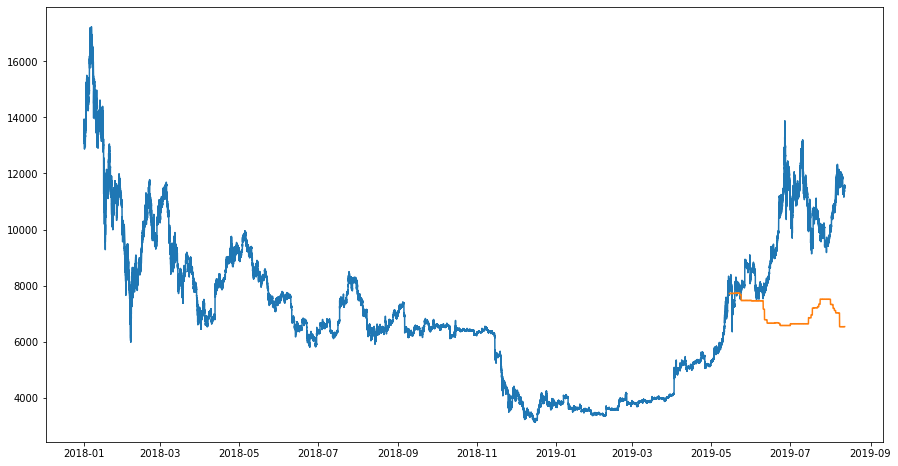

In [57]:
# plot predictions
plt.plot(df_cut['Timestamp'], df_cut['High'])
plt.plot(bitcoin_test['Timestamp'], bitcoin_test['hight_prediction'])

In [58]:
# Smaller window (much more smaller)

In [61]:
split_date = '2019-07-15'
df_cut_smaller = df.loc[df['Timestamp'] >= split_date].copy()

Text(0.5, 1.0, 'Bitcoin price 2019-07-15 to 2019-08-12')

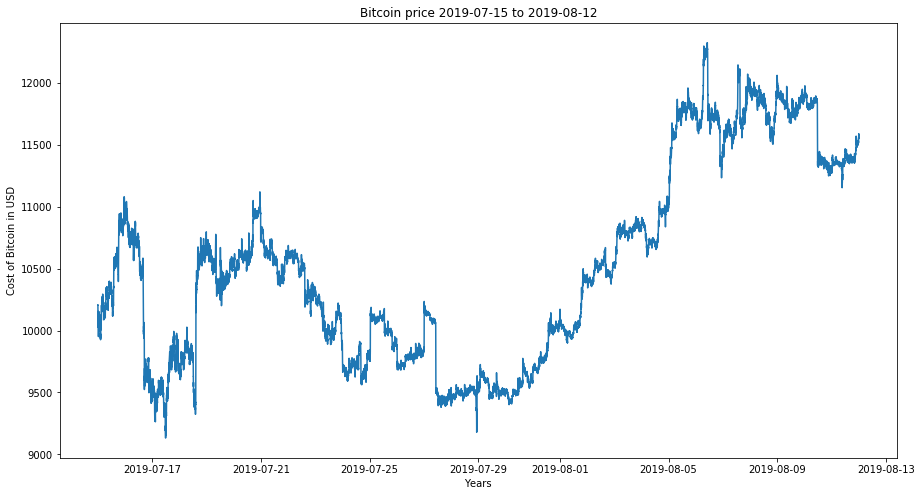

In [64]:
plt.plot(df_cut_smaller['Timestamp'], df_cut_smaller['High'])
plt.xlabel("Years")
plt.ylabel("Cost of Bitcoin in USD")
plt.title("Bitcoin price 2019-07-15 to 2019-08-12")

In [65]:
train_split_smaller = '2019-08-07'
bitcoin_train_smaller = df_cut_smaller.loc[df_cut_smaller['Timestamp'] <= train_split_smaller].copy()
bitcoin_test_smaller = df_cut_smaller.loc[df_cut_smaller['Timestamp'] > train_split_smaller].copy()

In [67]:
X_train_sml, y_train_sml = create_features(bitcoin_train_smaller)
X_test_sml, y_test_sml = create_features(bitcoin_test_smaller)

In [68]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train_sml, y_train_sml,
        eval_set=[(X_train_sml, y_train_sml), (X_test_sml, y_test_sml)],
        early_stopping_rounds=50,
        verbose=False) # too much logs 

C:\Users\Matthew\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Matthew\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[23:31:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [69]:
bitcoin_test_smaller['high_prediction'] = reg.predict(X_test_sml)

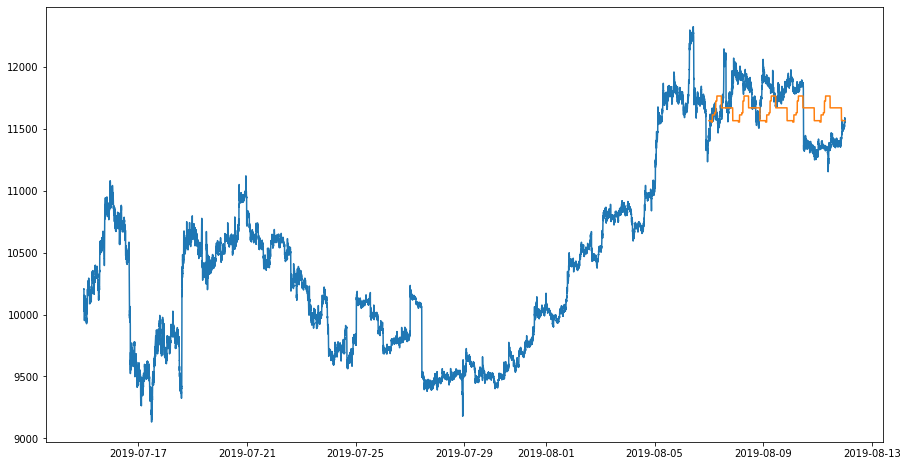

In [70]:
plt.plot(df_cut_smaller['Timestamp'], df_cut_smaller['High'])
plt.plot(bitcoin_test_smaller['Timestamp'], bitcoin_test_smaller['high_prediction'])

### Predictions - using ETS (much more smaller window)

In [98]:
y_hat_avg = bitcoin_test_smaller.copy()
fit1 = ExponentialSmoothing(np.asarray(bitcoin_train_smaller['High']), seasonal_periods=365, trend='add', seasonal='mul').fit() 

y_hat_avg['Holt_Winter'] = fit1.forecast(len(bitcoin_test_smaller))

C:\Users\Matthew\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


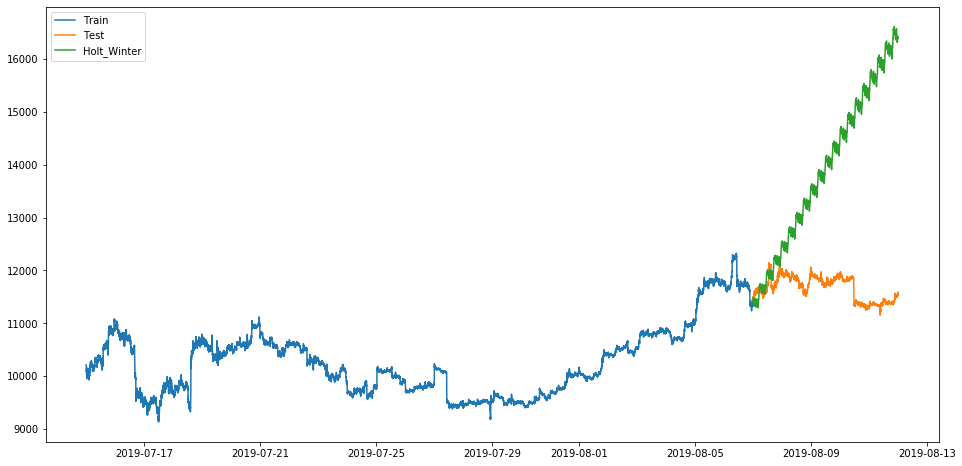

In [99]:
plt.figure(figsize=(16,8))
plt.plot(bitcoin_train_smaller['Timestamp'], bitcoin_train_smaller['High'], label='Train')
plt.plot(bitcoin_test_smaller['Timestamp'], bitcoin_test_smaller['High'], label='Test')
plt.plot(bitcoin_test_smaller['Timestamp'], y_hat_avg['Holt_Winter'], '-', label='Holt_Winter')
plt.legend(loc='best')
plt.show()

As presented above EST is a terrible choice for predicting non-seasonal data.